# Minor Flood Frequency and Duration

:::{glue:figure} threshold_counts_fig
:figclass: margin
:alt: Hello Friends I'm Trying!
:::

:::{glue:figure} duration_fig
:figclass: margin
:::

:::{important}
:class: myclass1,myclass2
:name: appropriated
This file is taken from https://github.com/jpotemra/PCCM/blob/main/Chapter%205%3A%20Sea%20Level/Malakal_SL_FloodFrequency.ipynb to demonstrate how it might work in a juptyer book context.
It has been adapted (a lot).
:::

Here we will plot two indicators concerning flooding at the Malakal tide gauge, after first taking a general look at the type of data we are able to plot from the UHSLC. These indicators are based on a 'flooding' threshold, using [relative sea level](https://tidesandcurrents.noaa.gov/sltrends/faq.html). 



*Thoughts*:
1. Interactivity? There's a launch button but I can disable it if we'd rather have this be static. (Can do it with binder.)
2. Not sure about major structure here. Right now this notebook is in the Intra-Annual file, which doesn't make any sense. But separating the annual and intra-annual seems like they'd be mostly the same...
3. This should go on github soon, but who should primary 'owner' be? (Mine is currently under my ucsd address. No bueno.)


## Setup

We first need to import the necessary libraries, access the data, and make a quick plot to ensure we will be analyzing the right thing.

### Import necessary libraries.

In [1]:
import xarray as xr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
from urllib.request import urlretrieve #used for downloading files
from myst_nb import glue #used for figure numbering when exporting to LaTeX
import scipy.stats as stats #used for fitting distributions
import requests #used for downloading files
from bs4 import BeautifulSoup #for parsing html
import seaborn as sns #for plotting


 ###  Retrieve the Tide Station(s) Data Set(s)

 #TODO: turn this section into a dropdown of available stations to pull from

Next, we'll access data from the UHSLC. The Malakala tide gauge has the UHSLC ID: 7. We will import the netcdf file into our current data directory, and take a peek at the dataset. We will also import the datums for this location. 

In [2]:
uhslc_id = 7
fname = f'h{uhslc_id:03}.nc' # h for hourly, d for daily
datadir = './'
url = "https://uhslc.soest.hawaii.edu/data/netcdf/fast/hourly/"

path = os.path.join(datadir, fname)

if not os.path.exists(path):
    urlretrieve(os.path.join(url, fname), path)
    
data_xr = xr.open_dataset(fname)
data_xr

<xarray.Dataset>
Dimensions:               (record_id: 1, time: 477345)
Coordinates:
  * time                  (time) datetime64[ns] 1969-05-18T15:00:00 ... 2023-...
  * record_id             (record_id) int16 70
Data variables:
    sea_level             (record_id, time) float32 ...
    lat                   (record_id) float32 ...
    lon                   (record_id) float32 ...
    station_name          (record_id) |S7 ...
    station_country       (record_id) |S5 ...
    station_country_code  (record_id) float32 ...
    uhslc_id              (record_id) int16 ...
    gloss_id              (record_id) float32 ...
    ssc_id                (record_id) |S4 ...
    last_rq_date          (record_id) datetime64[ns] ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2023-12-07T14:34:12Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

and we'll save a few variables that will come up later for report generation.

In [3]:
station = str(data_xr.station_name.values)[3:10]
country = str(data_xr.station_country.values)[3:8]
startDateTime = str(data_xr.time.values[0])[:10]
endDateTime = str(data_xr.time.values[-1])[:10]
glue("station",station,display=False)
glue("country",country, display=False)
glue("startDateTime",startDateTime, display=False)
glue("endDateTime",endDateTime, display=False)


### Set the Datum to MHHW

```{margin} A Note on Datums

The sea level variable in the netcdf file is sea level **relative to the station datum**. For more information on the data processing of this gauge, see the [station metdata](https://uhslc.soest.hawaii.edu/rqds/pacific/doc/qa007b.dmt). 

```

In this example, we will set the datum to MHHW. This can be hard coded, or we can read in the [station datum information](https://uhslc.soest.hawaii.edu/stations/?stn=007#datums) from UHSLC. I'm not going to do this, because there's no elegant way to parse the datum table at the moment as far as I can tell. It's a simple call to the NOAA COOPS API if that's the data source, though. Instead I have a saved datums_007.csv file that we'll call from.

In [4]:
# read datums_007.csv
datumtable = pd.read_csv('../data/datums_007.csv', sep=',')

# extract the given datum from the dataframe
datumname = 'MHHW'
datum = datumtable[datumtable['Datum'] == datumname]['Value'].values[0]

# make sure datum is a float64
datum = np.float64(datum)

data_xr['datum'] = datum*1000 # convert to mm
data_xr['sea_level'] = data_xr['sea_level'] - data_xr['datum']

# assign units to datum and sea level
data_xr['datum'].attrs['units'] = 'mm'
data_xr['sea_level'].attrs['units'] = 'mm'

glue("datum", datum, display=False)
glue("datumname", datumname, display=False)

datumtable



,Datum,Value,Description
0,Status,14-Nov-2022,Processing Date
1,Epoch,01-Jan-1983 to 31-Dec-2001,Tidal Datum Analysis Period
2,MHHW,2.162,Mean Higher-High Water (m)
3,MHW,2.087,Mean High Water (m)
4,MTL,1.530,Mean Tide Level (m)
5,MSL,1.532,Mean Sea Level (m)
6,DTL,1.458,Mean Diurnal Tide Level (m)
7,MLW,0.974,Mean Low Water (m)
8,MLLW,0.753,Mean Lower-Low Water (m)
9,STND,0.000,Station Datum (m)


###  Assess Station Data Quality for the POR (1983-2022)

To do this, we'll plot all the sea level data to make sure our data looks correct, and then we'll truncate the data set to the time period of record (POR).

```{margin} Watch the units!
```{caution} Note that the sea_level variable here is in millimeters (mm)! If we want to plot things on a centimeter (cm) scale, we have to divide by 10.
```

Text(0, 0.5, 'Sea Level (cm, MHHW)')

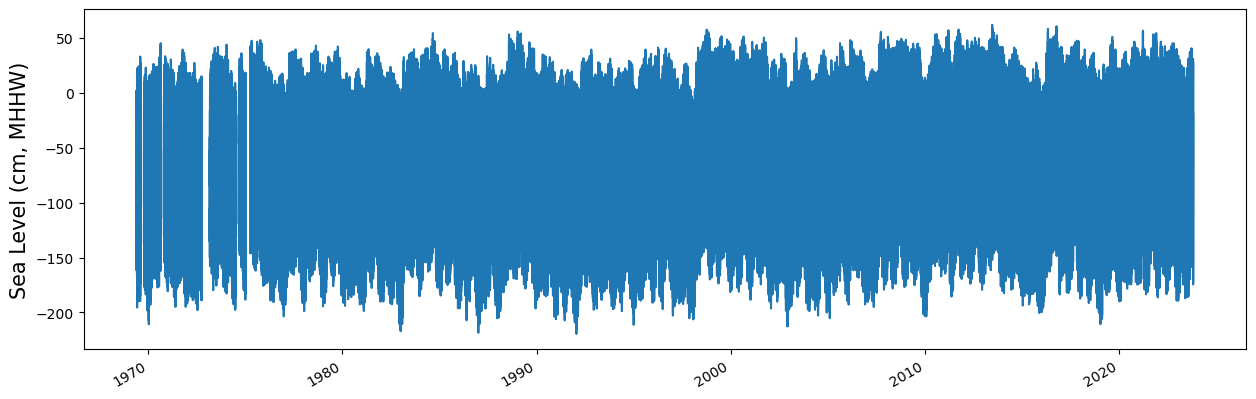

In [5]:
fig, ax = plt.subplots(sharex=True,figsize=[15,5])
fig.autofmt_xdate()
ax.plot(data_xr.time.values,data_xr.sea_level.T.values/10)

ax.set_ylabel(f'Sea Level (cm, {datumname})',fontsize=15) #divide by 10 to convert to cm


#### Identify epoch for the flood frequency analysis

Now, we'll calculate trend starting from the beginning of the tidal datum analysis period epoch to the last time processed. The  epoch information is given in the datums table. 

In [6]:
#get epoch start time from the epoch in the datumtable
epoch_times = datumtable[datumtable['Datum'] == 'Epoch']['Value'].values[0]

#parse epoch times into start time
epoch_start = epoch_times.split(' ')[0]
epoch_start = datetime.datetime.strptime(epoch_start, '%d-%b-%Y')

# and for now, end time the processind end time
epoch_end = datumtable[datumtable['Datum'] == 'Status']['Value'].values[0]

# convert to datetime object
epoch_end = datetime.datetime.strptime(epoch_end, '%d-%b-%Y')

hourly_data = data_xr.sel(dict(time=slice(epoch_start, epoch_end)))
hourly_data

glue("startEpochDateTime",epoch_start, display=False)
glue("endEpochDateTime",epoch_end, display=False)


and plot the hourly time series

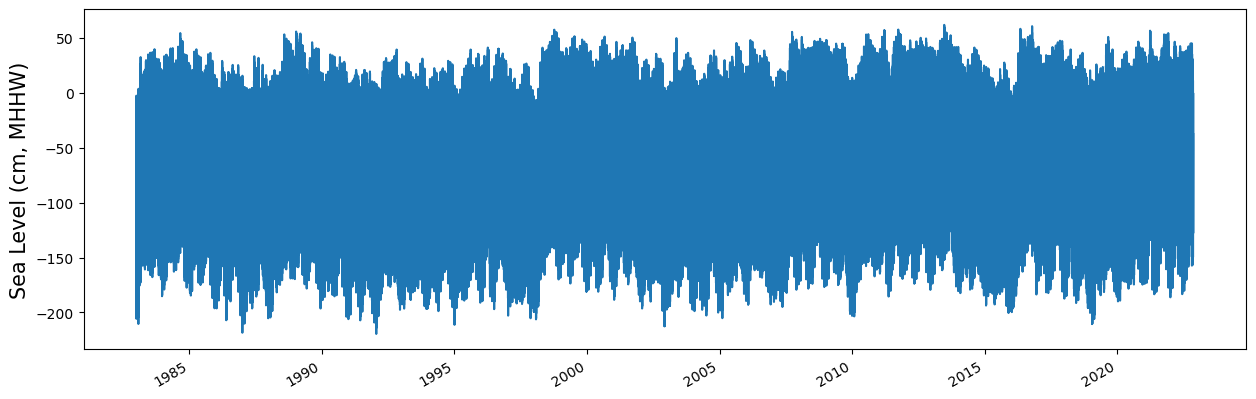

In [7]:
fig, ax = plt.subplots(sharex=True,figsize=[15,5])
fig.autofmt_xdate()
ax.plot(hourly_data.time.values,hourly_data.sea_level.T.values/10) #divide by 10 to convert to cm

ax.set_ylabel(f'Sea Level (cm, {datumname})',fontsize=15)

glue("TS_full_fig",fig,display=False)


:::{glue:figure} TS_full_fig
:name: "fig-TS_full"

Full time series at {glue:text}`station`,{glue:text}`country` tide gauge for the entire record from {glue:text}`startDateTime` to {glue:text}`endDateTime`. Note that the sea level is plotted in units of cm, relative to {glue:text}`datumname`.
:::

### Adjust the data from calendar year to storm year

Storm year goes from May-April. Need to consult with Ayesha about this.

In [8]:
hourly_data['day'] = (('time'), hourly_data.time.dt.dayofyear.data)
hourly_data['month'] = (('time'), hourly_data.time.dt.month.data)    
hourly_data['year'] = (('time'), hourly_data.time.dt.year.data)

# adjust year to storm year, where the storm year starts on May 1st
# if the month is less than 5, subtract a year
hourly_data['year_storm'] = (('time'), hourly_data.year.data - (hourly_data.month.data < 5))

hourly_data['year_storm'] = hourly_data['year_storm'].astype(int)

hourly_data['year_storm'].values

array([1982, 1982, 1982, ..., 2022, 2022, 2022])

### Assign a Threshold
The threshold used here to determine a flood event is 30 cm above MHHW.

In [9]:
threshold = 30 # in cm
glue("threshold",threshold,display=False)

hourly_data

<xarray.Dataset>
Dimensions:               (record_id: 1, time: 349489)
Coordinates:
  * time                  (time) datetime64[ns] 1983-01-01 ... 2022-11-14
  * record_id             (record_id) int16 70
Data variables: (12/15)
    sea_level             (record_id, time) float64 -251.0 -401.0 ... -373.0
    lat                   (record_id) float32 ...
    lon                   (record_id) float32 ...
    station_name          (record_id) |S7 b'Malakal'
    station_country       (record_id) |S5 b'Palau'
    station_country_code  (record_id) float32 ...
    ...                    ...
    last_rq_date          (record_id) datetime64[ns] ...
    datum                 float64 2.162e+03
    day                   (time) int64 1 1 1 1 1 1 1 ... 317 317 317 317 317 318
    month                 (time) int64 1 1 1 1 1 1 1 1 ... 11 11 11 11 11 11 11
    year                  (time) int64 1983 1983 1983 1983 ... 2022 2022 2022
    year_storm            (time) int64 1982 1982 1982 1982 ... 2022 2022 2022
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2023-12-07T14:34:12Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [10]:
# Assuming year_storm is created from the 'time' column
hourly_data['year_storm'] = hourly_data['time'].dt.year
hourly_data['year_storm'] = hourly_data['year_storm'].astype(int)

## Calculate and Plot Flood Frequency
To analyze flood frequency, we will look for daily maximum sea levels for each day in our dataset, following {cite:t}`thompson_statistical_2019` and others. Then, we can group our data by year and month to visualize temporal patterns in daily SWL exceedance.   

:::{glue:figure} histogram_fig
:name: "fig-histogram"
:figclass: margin

Histogram of daily maximum water levels at {glue:text}`station`,{glue:text}`country` tide gauge for the entire record from {glue:text}`startEpochDateTime` to {glue:text}`endEpochDateTime`, relative to {glue:text}`datunname`. The dashed red line indicates the chosen threshold of {glue:text}`threshold` cm.



In [11]:
# Resample the hourly data to daily maximum sea level
SL_daily_max = hourly_data.resample(time='D').max()
SL_daily_max

<xarray.Dataset>
Dimensions:               (time: 14563, record_id: 1)
Coordinates:
  * record_id             (record_id) int16 70
  * time                  (time) datetime64[ns] 1983-01-01 ... 2022-11-14
Data variables: (12/15)
    sea_level             (time, record_id) float64 -23.0 -109.0 ... 1.0 -373.0
    lat                   (time, record_id) float32 7.33 7.33 7.33 ... 7.33 7.33
    lon                   (time, record_id) float32 134.5 134.5 ... 134.5 134.5
    station_name          (time, record_id) |S7 b'Malakal' ... b'Malakal'
    station_country       (time, record_id) |S5 b'Palau' b'Palau' ... b'Palau'
    station_country_code  (time, record_id) float32 585.0 585.0 ... 585.0 585.0
    ...                    ...
    last_rq_date          (time, record_id) datetime64[ns] 2018-12-31T22:59:5...
    datum                 (time) float64 2.162e+03 2.162e+03 ... 2.162e+03
    day                   (time) int64 1 2 3 4 5 6 7 ... 313 314 315 316 317 318
    month                 (time) int64 1 1 1 1 1 1 1 1 ... 11 11 11 11 11 11 11
    year                  (time) int64 1983 1983 1983 1983 ... 2022 2022 2022
    year_storm            (time) int64 1983 1983 1983 1983 ... 2022 2022 2022
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2023-12-07T14:34:12Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

Text(0.5, 1.0, 'Sea Level Daily Maximum Time Series')

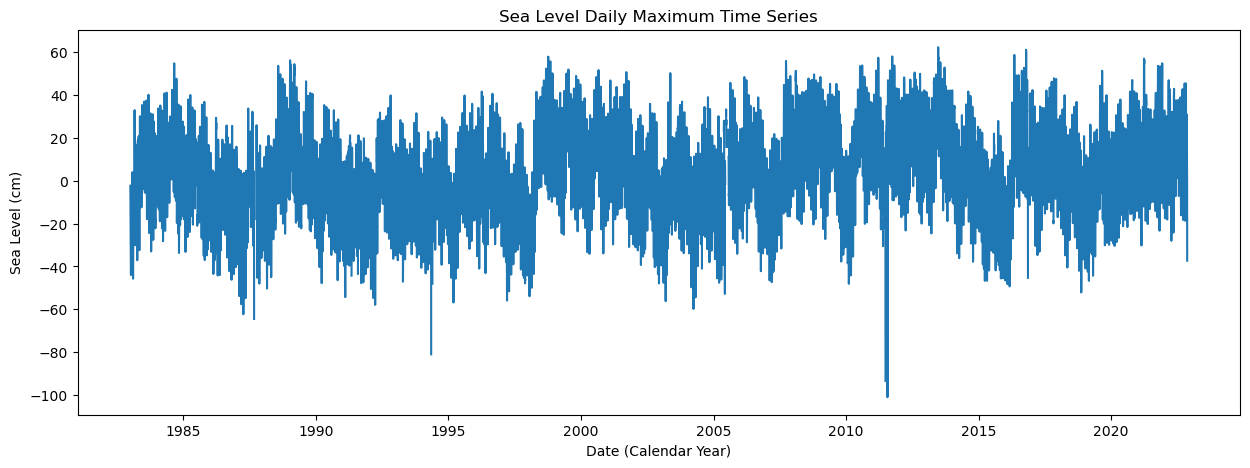

In [12]:
# make a new figure that is 15 x 5
fig, ax = plt.subplots(sharex=True,figsize=[15,5])
plt.plot(SL_daily_max.time.values, SL_daily_max.sea_level.values/10)
plt.xlabel('Date (Calendar Year)')
plt.ylabel('Sea Level (cm)')
plt.title('Sea Level Daily Maximum Time Series')

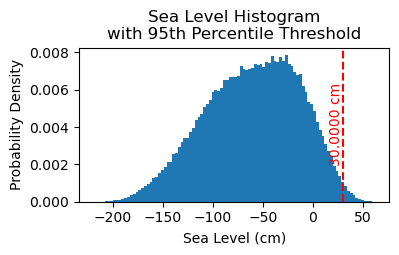

In [13]:
# Make a pdf of the data with 95th percentile threshold

sea_level_data_cm = hourly_data['sea_level'].values/10 # convert to cm
#remove nans
sea_level_data_cm = sea_level_data_cm[~np.isnan(sea_level_data_cm)]

fig, ax = plt.subplots(figsize=(4,2))
ax.hist(sea_level_data_cm, bins=100, density=True, label='Sea Level Data')

ax.axvline(threshold, color='r', linestyle='--', label='Threshold: {:.4f} cm'.format(threshold))
ax.set_xlabel('Sea Level (cm)')
ax.set_ylabel('Probability Density')
# make the title two lines
ax.set_title('Sea Level Histogram\nwith 95th Percentile Threshold')

# add label to dashed line
# get value of middle of y-axis for label placement
ymin, ymax = ax.get_ylim()
yrange = ymax - ymin
y_middle = ymin + yrange/2

ax.text(threshold, y_middle, '{:.4f} cm'.format(threshold), rotation=90, va='center', ha='right', color='r')
glue("histogram_fig", fig, display=False)

In [14]:
# Find all days where sea level exceeds the threshold
flood_day = (SL_daily_max.sea_level > threshold)

SL_daily_max['flood_day'] = flood_day

# Filtering the dataset for flood hours and selecting relevant variables
flood_days_data = SL_daily_max.where(SL_daily_max.flood_day, drop=True)[['year_storm']]

# Converting the dataset to a DataFrame
flood_days_df = flood_days_data.to_dataframe().reset_index()

# Grouping by 'year_storm' and counting the number of flood days
flood_days_per_year = flood_days_df.groupby('year_storm').size().reset_index(name='flood_days_count')

In [15]:
# Find all hours where sea level exceeds the threshold
flood_hour = (hourly_data.sea_level > threshold)

hourly_data['flood_hour'] = flood_hour

# Filtering the dataset for flood hours and selecting relevant variables
flood_hours_data = hourly_data.where(hourly_data.flood_hour, drop=True)[['year_storm']]

# Converting the dataset to a DataFrame
flood_hours_df = flood_hours_data.to_dataframe().reset_index()

# Grouping by 'year_storm' and counting the number of flood hours
flood_hours_per_year = flood_hours_df.groupby('year_storm').size().reset_index(name='flood_hours_count')

### Plot Flood Frequency Counts 

The flood frequency counts are defined as the number of time periods that exceed a given threshold within a year. This plot follows {cite:t}`center_for_operational_oceanographic_products_and_services_us_sea_2014`.

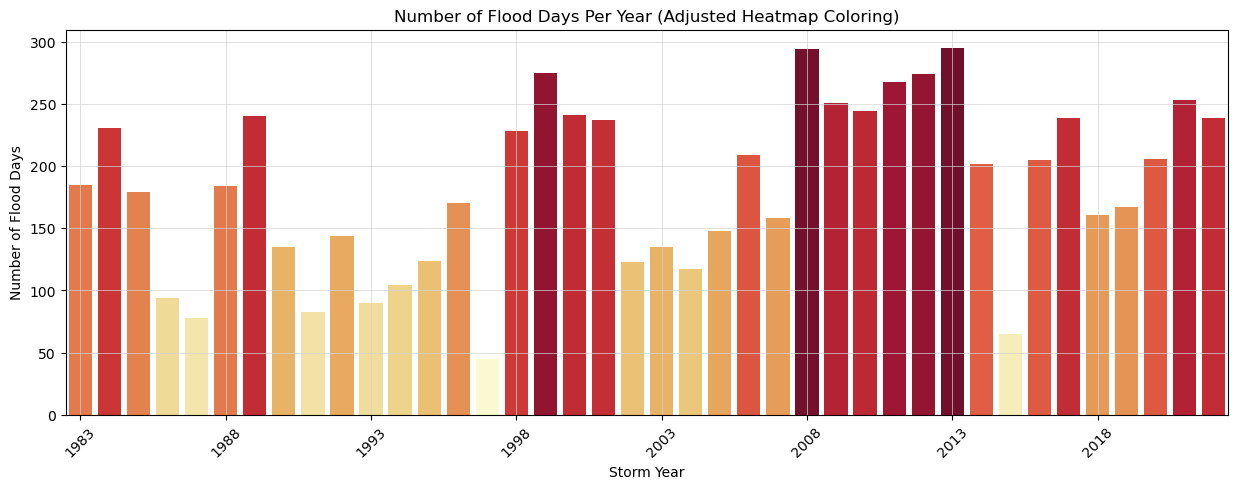

In [16]:
# Adjusting the heatmap palette to improve readability
adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)
norm = plt.Normalize(flood_days_per_year['flood_days_count'].min(), flood_days_per_year['flood_days_count'].max())
colors = [adjusted_heatmap_palette(norm(value)) for value in flood_days_per_year['flood_days_count']]

# Plotting with the adjusted settings
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(
    x='year_storm', 
    y='flood_days_count', 
    hue='year_storm', 
    data=flood_days_per_year, 
    palette=colors,
    dodge=False,
    legend=False
)
ax.set_xticks(range(0, len(flood_days_per_year), 5))  # Setting x-ticks to show every 5th year
year_ticks = flood_days_per_year['year_storm'][::5].astype(int)  # Selecting every 5th year for the x-axis
ax.set_xticklabels(year_ticks, rotation=45)

# Adding a light gray grid
ax.grid(color='lightgray', linestyle='-', linewidth=0.5)

ax.set_xlabel('Storm Year')
ax.set_ylabel('Number of Flood Days')
ax.set_title('Number of Flood Days Per Year (Adjusted Heatmap Coloring)')
             
glue("threshold_counts_days_fig", fig, display=False)

```{glue:figure} threshold_counts_days_fig
:name: "fig-threshold_counts"

Flood frequency counts above a threshold of {glue:text}`threshold:.3f` cm per year at {glue:text}`station`,{glue:text}`country` tide gauge from {glue:text}`startEpochDateTime` to {glue:text}`endEpochDateTime`. 
```

### Plot Flood Duration

This next plot examines the average duration of flooding events as defined by the threshold. 
I have a few issues with this plot being "duration," as it's just counts of hours above the threshold. These hours need not be continuous...which to me is what duration is all about. Anyway, we carry on.

```{margin}
Also I'm very aware that this colorbar is polar opposite of what it normally should be. Not going to bother with it for now.
```

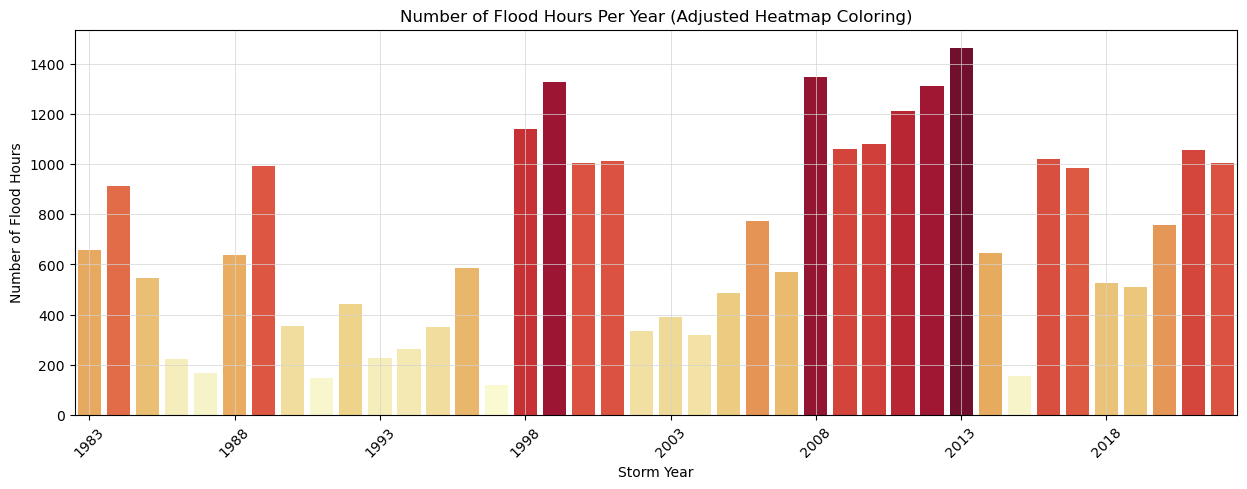

In [17]:
# This is the same as the previous cell, but with 'flood_hours_count' instead of 'flood_days_count' and 'flood_hours_per_year' instead of 'flood_days_per_year'. This is bad coding. I should have made a function to do this.  
# But there are bigger fish to fry right now.


# Adjusting the heatmap palette to improve readability
adjusted_heatmap_palette = sns.color_palette("YlOrRd", as_cmap=True)
norm = plt.Normalize(flood_hours_per_year['flood_hours_count'].min(), flood_hours_per_year['flood_hours_count'].max())
colors = [adjusted_heatmap_palette(norm(value)) for value in flood_hours_per_year['flood_hours_count']]

# Plotting with the adjusted settings
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(
    x='year_storm', 
    y='flood_hours_count', 
    hue='year_storm', 
    data=flood_hours_per_year, 
    palette=colors,
    dodge=False,
    legend=False
)
ax.set_xticks(range(0, len(flood_hours_per_year), 5))  # Setting x-ticks to show every 5th year
year_ticks = flood_hours_per_year['year_storm'][::5].astype(int)  # Selecting every 5th year for the x-axis
ax.set_xticklabels(year_ticks, rotation=45)

# Adding a light gray grid
ax.grid(color='lightgray', linestyle='-', linewidth=0.5)

ax.set_xlabel('Storm Year')
ax.set_ylabel('Number of Flood Hours')
ax.set_title('Number of Flood Hours Per Year (Adjusted Heatmap Coloring)')

glue("duration_fig", fig, display=False)

```{glue:figure} duration_fig
:name: "fig-duration"

Average flood duration in hours above a threshold of {glue:text}`threshold:.3f` cm per year at {glue:text}`station`,{glue:text}`country` tide gauge from {glue:text}`startEpochDateTime` to {glue:text}`endEpochDateTime`. 
```

## Calculate the percent change over POR at the tide station for both frequency and duration.
Calculate the percent change over POR at the tide station/s, for both Frequency and Duration – TABLE 


## Create a map
Create a Map with an icon/s depicting percent change over POR at the tide station/s, for both Frequency and Duration - MAP


---


___
## Citations

:::{bibliography}
:style: alpha
:filter: docname in docnames
:::